In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from datasets import load_dataset

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
dataset_name = 'dataset_players_statistics'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

# Load data and split

In [3]:
train = pd.read_csv(out)
train = train.drop(['game'], axis=1)
target = 'result'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
train

,bluetopgp,bluetopwr,bluetopkda,bluejunglegp,bluejunglewr,bluejunglekda,bluemidgp,bluemidwr,bluemidkda,blueadcgp,...,redmidwr,redmidkda,redadcgp,redadcwr,redadckda,redsupportgp,redsupportwr,redsupportkda,result,Set
0,8,0.50,2.9,27,0.85,5.9,54,0.74,10.2,10,...,0.46,3.6,21,0.57,4.3,10,0.60,2.5,0,train
1,14,0.36,2.6,63,0.63,5.1,1,0.00,1.0,20,...,0.70,5.0,10,0.70,5.3,11,0.55,2.8,1,train
2,14,0.36,2.6,63,0.63,5.1,4,0.25,2.3,2,...,0.50,3.8,10,0.70,5.3,11,0.55,2.8,1,train
3,2,0.00,0.9,5,0.60,3.9,36,0.75,6.2,5,...,0.67,5.2,43,0.60,6.3,4,0.75,4.5,1,train
4,16,0.56,2.8,11,0.55,3.6,50,0.64,6.1,5,...,0.67,5.2,43,0.60,6.3,2,0.50,1.4,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,6,0.67,2.9,5,0.40,6.1,11,0.45,4.8,3,...,0.80,3.8,1,0.00,3.0,3,0.67,4.4,0,test
2836,5,0.80,4.0,1,1.00,12.0,3,0.67,6.0,2,...,0.33,1.9,19,0.47,3.7,4,0.75,2.3,0,test
2837,12,0.50,2.4,6,0.67,6.0,3,1.00,6.3,4,...,0.69,7.4,20,0.70,4.3,15,0.53,2.8,0,train
2838,5,0.60,2.6,4,0.50,3.0,5,0.60,5.0,3,...,0.45,4.8,12,0.67,5.0,11,0.73,4.3,1,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [4]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

bluetopgp 56
bluetopwr 74
bluetopkda 115
bluejunglegp 48
bluejunglewr 73
bluejunglekda 131
bluemidgp 62
bluemidwr 78
bluemidkda 141
blueadcgp 67
blueadcwr 80
blueadckda 144
bluesupportgp 63
bluesupportwr 77
bluesupportkda 111
redtopgp 56
redtopwr 77
redtopkda 108
redjunglegp 49
redjunglewr 72
redjunglekda 125
redmidgp 64
redmidwr 73
redmidkda 142
redadcgp 65
redadcwr 80
redadckda 135
redsupportgp 63
redsupportwr 76
redsupportkda 110
result 2
Set 3


# Define categorical features for categorical embeddings

In [5]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [6]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Network parameters

In [7]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [8]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
)

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Self Supervised Training

In [9]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [10]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=200,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,

) 

epoch 0  | loss: 4.05531 | val_0_unsup_loss: 1.20635 |  0:00:00s
epoch 1  | loss: 2.68673 | val_0_unsup_loss: 1.15015 |  0:00:00s
epoch 2  | loss: 2.20495 | val_0_unsup_loss: 1.11331 |  0:00:00s
epoch 3  | loss: 1.80837 | val_0_unsup_loss: 1.08973 |  0:00:00s
epoch 4  | loss: 1.57841 | val_0_unsup_loss: 1.08148 |  0:00:00s
epoch 5  | loss: 1.39684 | val_0_unsup_loss: 1.07038 |  0:00:01s
epoch 6  | loss: 1.27121 | val_0_unsup_loss: 1.06076 |  0:00:01s
epoch 7  | loss: 1.17462 | val_0_unsup_loss: 1.05333 |  0:00:01s
epoch 8  | loss: 1.1322  | val_0_unsup_loss: 1.04681 |  0:00:01s
epoch 9  | loss: 1.10022 | val_0_unsup_loss: 1.03982 |  0:00:01s
epoch 10 | loss: 1.07374 | val_0_unsup_loss: 1.03237 |  0:00:02s
epoch 11 | loss: 1.05342 | val_0_unsup_loss: 1.02595 |  0:00:02s
epoch 12 | loss: 1.04614 | val_0_unsup_loss: 1.02161 |  0:00:02s
epoch 13 | loss: 1.03518 | val_0_unsup_loss: 1.01868 |  0:00:02s
epoch 14 | loss: 1.02974 | val_0_unsup_loss: 1.01553 |  0:00:02s
epoch 15 | loss: 1.02401 

/opt/ml/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [11]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [12]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

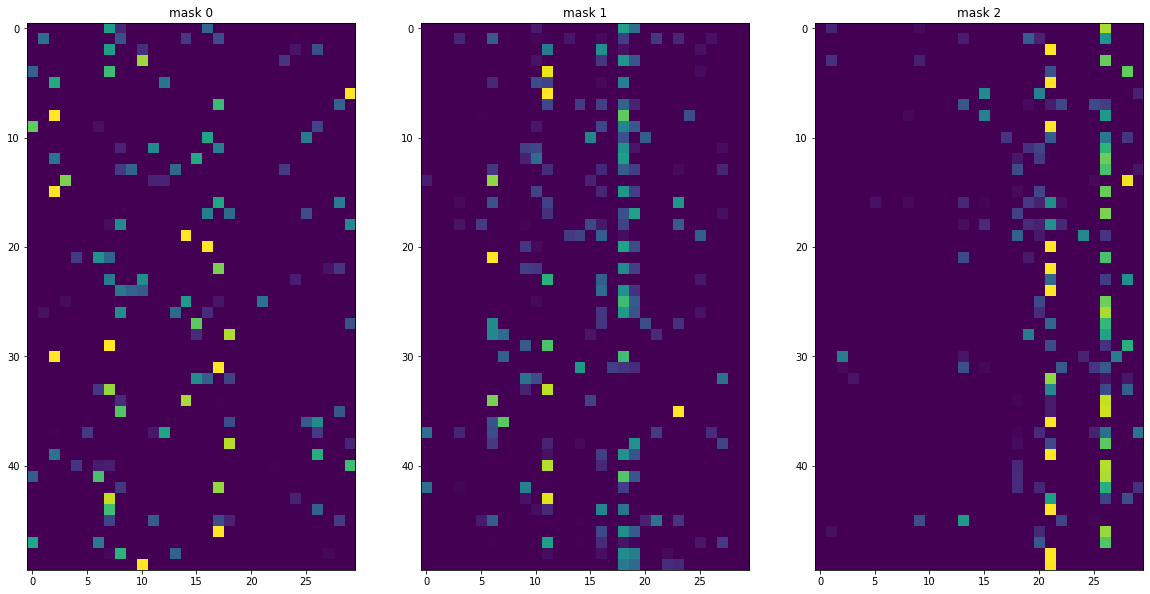

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


## Save and load the same way as other TabNet models

In [14]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [15]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

In [16]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=max_epochs , patience=200,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
    
) 

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_dims changed from [] to [56, 74, 115, 48, 73, 131, 62, 78, 141, 67, 80, 144, 63, 77, 111, 56, 77, 108, 49, 72, 125, 64, 73, 142, 65, 80, 135, 63, 76, 110]
  warnings.warn(wrn_msg)
/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  warnings.warn(wrn_msg)
/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:225: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1.21342 | train_accuracy: 0.52739 | valid_accuracy: 0.50181 |  0:00:00s
epoch 1  | loss: 0.84695 | train_accuracy: 0.53497 | valid_accuracy: 0.49458 |  0:00:00s
epoch 2  | loss: 0.74493 | train_accuracy: 0.55857 | valid_accuracy: 0.5343  |  0:00:00s
epoch 3  | loss: 0.69601 | train_accuracy: 0.54744 | valid_accuracy: 0.52347 |  0:00:00s
epoch 4  | loss: 0.69913 | train_accuracy: 0.56437 | valid_accuracy: 0.56318 |  0:00:01s
epoch 5  | loss: 0.67971 | train_accuracy: 0.59866 | valid_accuracy: 0.54152 |  0:00:01s
epoch 6  | loss: 0.66089 | train_accuracy: 0.60757 | valid_accuracy: 0.58123 |  0:00:01s
epoch 7  | loss: 0.66185 | train_accuracy: 0.62361 | valid_accuracy: 0.59567 |  0:00:01s
epoch 8  | loss: 0.64287 | train_accuracy: 0.6294  | valid_accuracy: 0.62094 |  0:00:02s
epoch 9  | loss: 0.6461  | train_accuracy: 0.63519 | valid_accuracy: 0.59928 |  0:00:02s
epoch 10 | loss: 0.64767 | train_accuracy: 0.64009 | valid_accuracy: 0.61733 |  0:00:02s
epoch 11 | loss: 0.62

/opt/ml/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


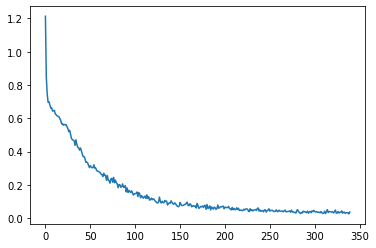

In [17]:
# plot losses
plt.plot(clf.history['loss'])

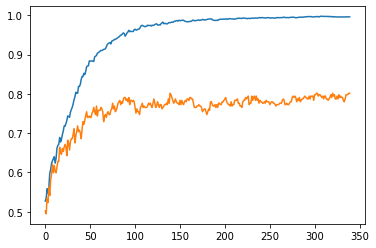

In [18]:
# plot acc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

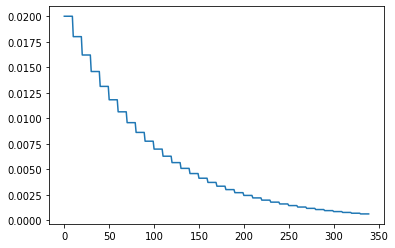

In [19]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [20]:
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_true=y_test, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])

preds_valid = clf.predict_proba(X_valid)
valid_acc = accuracy_score(y_true=y_valid, y_pred=[0 if x < 0.5 else 1 for x in preds_valid[:,1]])
print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR dataset_players_statistics : 0.8014440433212996
FINAL TEST SCORE FOR dataset_players_statistics : 0.7421383647798742


In [21]:
# check that best weights are used
assert np.isclose(valid_acc, np.max(clf.history['valid_accuracy']), atol=1e-6)

# Save and load Model

In [22]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [23]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [24]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_acc = accuracy_score(y_true=y_test, y_pred=[0 if x < 0.5 else 1 for x in loaded_preds[:,1]])
print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR dataset_players_statistics : 0.7421383647798742


In [25]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [26]:
clf.feature_importances_

array([0.01598982, 0.01800716, 0.02367898, 0.00210877, 0.03437221,
       0.01442321, 0.01175557, 0.14486877, 0.00641163, 0.01592587,
       0.09810505, 0.00616051, 0.00977749, 0.01063553, 0.00709562,
       0.00303326, 0.16258117, 0.02269318, 0.03113693, 0.18885745,
       0.        , 0.00697395, 0.06496055, 0.02347947, 0.01407862,
       0.00442405, 0.00085155, 0.01848711, 0.03449282, 0.00463368])

# Local explainability and masks

In [27]:
explain_matrix, masks = clf.explain(X_test)

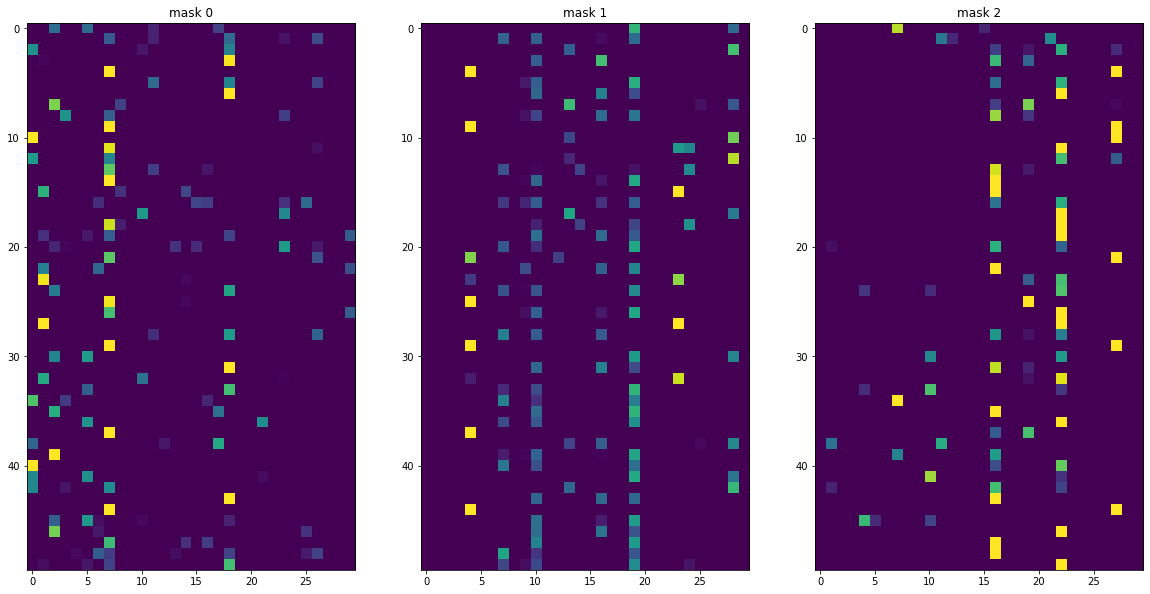

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [29]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=200,
        verbose=10)

[0]	validation_0-logloss:0.63199


/opt/conda/envs/lightweight/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-logloss:0.34838
[20]	validation_0-logloss:0.25060
[30]	validation_0-logloss:0.20870
[40]	validation_0-logloss:0.19068
[50]	validation_0-logloss:0.17812
[60]	validation_0-logloss:0.17450
[70]	validation_0-logloss:0.17261
[80]	validation_0-logloss:0.17270
[90]	validation_0-logloss:0.17324
[100]	validation_0-logloss:0.17638
[110]	validation_0-logloss:0.17937
[120]	validation_0-logloss:0.18057
[130]	validation_0-logloss:0.18322
[140]	validation_0-logloss:0.18429
[150]	validation_0-logloss:0.18294
[160]	validation_0-logloss:0.18616
[170]	validation_0-logloss:0.18507
[180]	validation_0-logloss:0.18377
[190]	validation_0-logloss:0.18518
[200]	validation_0-logloss:0.18866
[210]	validation_0-logloss:0.18874
[220]	validation_0-logloss:0.18948
[230]	validation_0-logloss:0.18926
[240]	validation_0-logloss:0.18960
[250]	validation_0-logloss:0.19161
[260]	validation_0-logloss:0.19431
[268]	validation_0-logloss:0.19555


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              nthread=8, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, ...)

In [30]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_acc = accuracy_score(y_true= y_valid, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(valid_acc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_true=y_test, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(test_acc)

0.9314079422382672
0.9119496855345912


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics   
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, min_samples_split=10, max_features=7)
forest.fit(X_train, y_train)

preds = np.array(forest.predict_proba(X_valid))
valid_acc = accuracy_score(y_true= y_valid, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(valid_acc)

preds = np.array(forest.predict_proba(X_test))
test_acc = accuracy_score(y_true=y_test, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(test_acc)


0.924187725631769
0.9245283018867925


In [34]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(max_iter=500)
logistic.fit(X_train, y_train)

preds = np.array(logistic.predict_proba(X_valid))
valid_acc = accuracy_score(y_true=y_valid, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(valid_acc)

preds = np.array(logistic.predict_proba(X_test))
test_acc = accuracy_score(y_true=y_test, y_pred=[0 if x < 0.5 else 1 for x in preds[:,1]])
print(test_acc)

0.9169675090252708
0.9056603773584906
